### 1. download data sets

Visit: https://www.kaggle.com/c/allstate-claims-severity/data <br\>
You need to accept the competition rules in order to download the datasets:
train.csv
test.csv

### 2. import packages

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import time
from copy import deepcopy
from sklearn.model_selection import train_test_split

### 3. read data + lexical encoding

In [2]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

test['loss'] = np.nan
data = pd.concat([train, test])

# lexical encoding (not recommended if the categorical feature is not ordinal)
categorical_list = list(data.select_dtypes(include=['object']).columns)
for column in categorical_list:
    data[column] = pd.factorize(data[column].values, sort=True)[0]

train  = data[data['loss'].notnull()]
train  = train.iloc[:10000]               # Use only first 10000 obs to save time
train2 = deepcopy(train)                  # make a copy for later use 
del train2['id']
test   = data[data['loss'].isnull()]

test_id = test['id']
y_train = train['loss'] 
del train['id']
del train['loss'] 
del test['id']
del test['loss']

### 4. take a look at the shape of data

In [3]:
print(train.shape)      # X_train
print(test.shape)       # X_test
print(y_train.shape)    # y_train

print(np.mean(y_train)) # used as base_score

(10000, 130)
(125546, 130)
(10000,)
3051.6737099999978


### 5. tune parameters- approach 1: xgb.cv

In [4]:
X_y_train = xgb.DMatrix(data=train, label=y_train)
X_test    = xgb.DMatrix(data=test)
params_recorder_1 = None

In [5]:
params = {
          'base_score': np.mean(y_train),
          'eta':  0.1,
          'max_depth': 3,
          'colsample_bytree': 0.5,
          'subsample': 0.7,
          'lambda': 1.3,
          'gamma': 1,
          'seed': 2017,
          'updater':'grow_gpu_hist',
          'tree_method' :'exact',
          'objective'   :'reg:linear',
          'eval_metric' :'rmse'
         }

In [6]:
start_time = time.time()
cv_table = xgb.cv(params=params,  
                  dtrain=X_y_train, 
                  num_boost_round=10000,
                  nfold=5,
                  verbose_eval = 20,
                  early_stopping_rounds = 30,
                  seed =1)
print("--- %s seconds ---" % (time.time() - start_time))

[0]	train-rmse:2784.44+11.6815	test-rmse:2787.8+44.5866
[20]	train-rmse:2127.45+9.3654	test-rmse:2194.5+31.9952
[40]	train-rmse:1972.64+12.4995	test-rmse:2089.82+35.1298
[60]	train-rmse:1893.73+11.3361	test-rmse:2047.61+34.2299
[80]	train-rmse:1843.73+11.5044	test-rmse:2028.08+32.4671
[100]	train-rmse:1807.04+9.28922	test-rmse:2017.24+30.6999
[120]	train-rmse:1777.64+9.92172	test-rmse:2011.85+32.3447
[140]	train-rmse:1751.39+11.0392	test-rmse:2008.14+30.2259
[160]	train-rmse:1727.13+10.4872	test-rmse:2004.69+30.2169
[180]	train-rmse:1706.79+9.73225	test-rmse:2003.38+27.9719
[200]	train-rmse:1687.08+10.0251	test-rmse:2005.1+27.4781
--- 5.048335790634155 seconds ---


#### record parameters

In [7]:
params2 = {}
for item in params:
    params2[item] = [params[item]]
observation = pd.DataFrame(params2)
observation['round'] =  cv_table.shape[0]
observation['CV_error'] =  cv_table.iloc[cv_table.shape[0]-1][cv_table.columns[0]]
observation['Train_error'] =  cv_table.iloc[cv_table.shape[0]-1][cv_table.columns[2]]

displayed_columns = ['eta', 'max_depth', 'gamma', 'lambda', 'colsample_bytree', 'subsample',
                     'base_score', 'seed', 'round', 'eval_metric', 'CV_error', 'Train_error']
observation = observation[displayed_columns]
observation.columns = ['eta', 'max_d', 'gamma', 'lambda', 'colsample', 'subsample',
                       'base', 'seed', 'round', 'eval','CV_error', 'Train_error']

observation.head()

,eta,max_d,gamma,lambda,colsample,subsample,base,seed,round,eval,CV_error,Train_error
0,0.1,3,1,1.3,0.5,0.7,3051.67371,2017,176,rmse,2002.734473,1712.329639


In [8]:
params_recorder_1 = pd.concat([params_recorder_1, observation])
params_recorder_1.head(20)

,eta,max_d,gamma,lambda,colsample,subsample,base,seed,round,eval,CV_error,Train_error
0,0.1,3,1,1.3,0.5,0.7,3051.67371,2017,176,rmse,2002.734473,1712.329639


#### build predictive models

In [9]:
model = xgb.train(params=params,  
                  dtrain=X_y_train, 
                  num_boost_round=215)

### 5. tune parameters- approach 2: watch list

In [10]:
params_recorder_2 = None

train, valid = train_test_split(train2, test_size = 0.2, random_state = 42)
y_train = train['loss']
y_valid = valid['loss']
del train['loss']
del valid['loss']

DM_train = xgb.DMatrix(data=train, label=y_train)
DM_valid = xgb.DMatrix(data=valid, label=y_valid)
watchlist = [(DM_train, 'train'), (DM_valid, 'valid')]

In [11]:
params = {
          'base_score': np.mean(y_train),
          'eta':  0.1,
          'max_depth': 4,
          'colsample_bytree': 0.7,
          'subsample': 0.7,
          'lambda': 1.3,
          'gamma': 1.2,
          'seed': 2017,
          'tree_method' :'exact',
          'objective'   :'reg:linear',
          'eval_metric' :'rmse'
         }

model  = xgb.train(params=params,  
                   dtrain=DM_train, 
                   num_boost_round=10000,
                   evals=watchlist,
                   early_stopping_rounds=50,
                   verbose_eval=20
                  )

[0]	train-rmse:2750.13	valid-rmse:2801.14
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:2007.46	valid-rmse:2181.77
[40]	train-rmse:1824.57	valid-rmse:2088.74
[60]	train-rmse:1737.65	valid-rmse:2059.74
[80]	train-rmse:1672.63	valid-rmse:2049.05
[100]	train-rmse:1628.29	valid-rmse:2044.9
[120]	train-rmse:1586.64	valid-rmse:2033.96
[140]	train-rmse:1551.08	valid-rmse:2044.02
[160]	train-rmse:1517.73	valid-rmse:2043.38
Stopping. Best iteration:
[120]	train-rmse:1586.64	valid-rmse:2033.96



#### record parameters

In [12]:
params2 = {}
for item in params:
    params2[item] = [params[item]]
observation = pd.DataFrame(params2)
observation['round'] =  int(model.attributes()['best_iteration'])
observation['Valid_error'] =  float(model.attributes()['best_score'])

displayed_columns = ['eta', 'max_depth', 'gamma', 'lambda', 'colsample_bytree', 'subsample',
                     'base_score', 'seed', 'round', 'eval_metric', 'Valid_error']
observation = observation[displayed_columns]
observation.columns = ['eta', 'max_d', 'gamma', 'lambda', 'colsample', 'subsample',
                       'base', 'seed', 'round', 'eval', 'Valid_error']

observation.head()

,eta,max_d,gamma,lambda,colsample,subsample,base,seed,round,eval,Valid_error
0,0.1,4,1.2,1.3,0.7,0.7,3042.902434,2017,120,rmse,2033.956787


In [13]:
params_recorder_2 = pd.concat([params_recorder_2, observation])
params_recorder_2.head(20)

,eta,max_d,gamma,lambda,colsample,subsample,base,seed,round,eval,Valid_error
0,0.1,4,1.2,1.3,0.7,0.7,3042.902434,2017,120,rmse,2033.956787


### 6. plot feature importance (XGBoost 0.6)

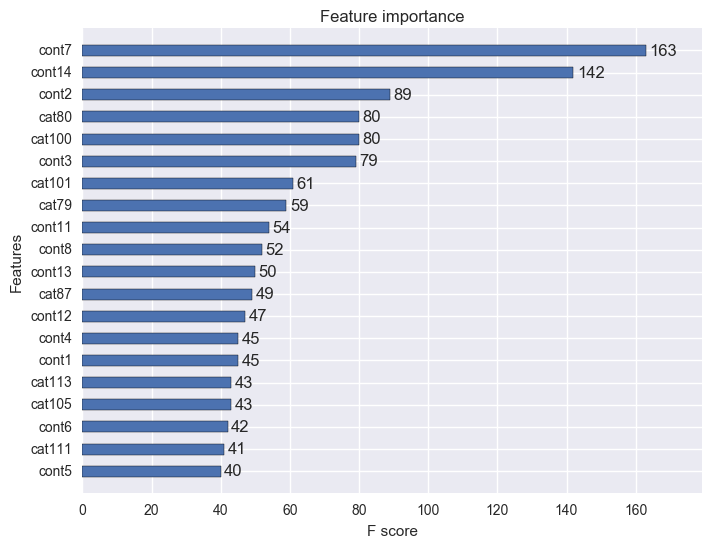

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax)

### 7. plot classfication trees (install graphviz first)

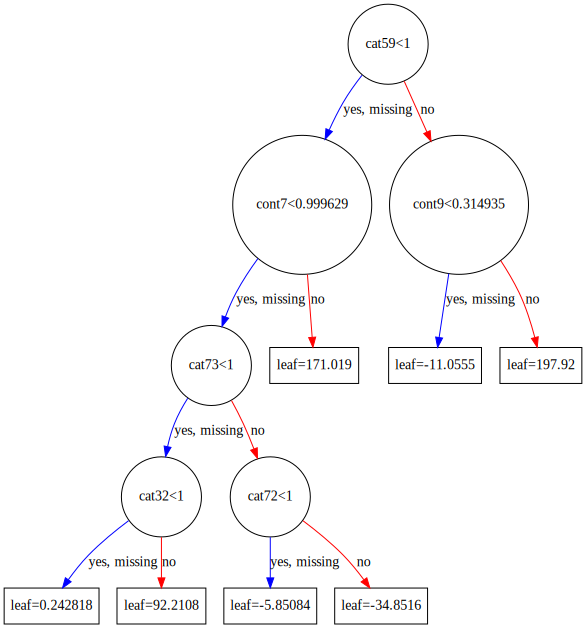

In [15]:
xgb.to_graphviz(booster = model, num_trees=100)

### 8. save and load model

In [16]:
model.save_model('XGBoost_1.model')
del model
model = xgb.Booster(model_file = 'XGBoost_1.model')

### 9. make predictions

In [17]:
y_test = model.predict(X_test)   
submission = pd.DataFrame({'id':test_id, 'loss':y_test})
submission.head(10)

,id,loss
0,4,1851.045776
1,6,1949.475342
2,9,10304.735352
3,12,5521.456055
4,15,1133.838989
5,17,1901.340088
6,21,1900.847412
7,28,709.679688
8,32,2493.802002
9,43,2666.297119
